In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Imports and read file to corpus

In [3]:
# Use this block to download necessary packets for nltk

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [4]:
import nltk
import gensim
import re
import pickle
from gensim import corpora
from gensim.parsing.preprocessing import *
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import pyLDAvis.gensim
import numpy as np
import os
from pprint import pprint
import pickle

# Figures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd

# For MAC OS
mallet_path = 'mallet-2.0.8/bin/mallet'
os.environ['MALLET_HOME'] = 'mallet-2.0.8'

# For Windows OS
#os.environ['MALLET_HOME'] = 'C:\\mallet'
#mallet_path = 'C:\\mallet\\bin\\mallet.bat'

In [9]:
def readFile(folder, filename):
    fileData = ""
    file = open(folder + "/" + filename, 'r', encoding='utf8')
    fileData = file.read().splitlines()
    file.close
    return fileData

In [20]:
def createEmptyFile(filename):
    file = open("authors/" + filename, 'w').close()

In [21]:
def saveToFile(filename, abstract):
    if len(abstract) > 0:
        file = open("authors/" + filename, 'a')
        try:
            file.writelines(abstract + "\n")
        except:
            file.write("\n")
            print("\n Write exception")
        file.close
        print('+', end='')
        return True
    else:
        print('-', end='')
        return False

# TODO
* fix blankspace problem with authors in USENIX

In [6]:
corpus = []

# Used later to make diagrams
yearList = []
conferenceList = []
author = []

for i in range (2000,2021):
    conference = readFile('abstracts', 'usenix' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('Usenix')
        yearList.append(i)
    authors = readFile('authors', 'usenix' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)
        
for i in range (2000,2021):
    conference = readFile('abstracts', 'css' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('CSS')
        yearList.append(i)
    authors = readFile('authors', 'css' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)     

for i in range (2000,2021):   
    conference = readFile('abstracts', 'ieee' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('IEEE')
        yearList.append(i)
    authors = readFile('authors', 'ieee' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)

for i in range (2000,2021):
    conference = readFile('abstracts', 'ndss' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('NDSS')
        yearList.append(i)
    authors = readFile('authors', 'ndss' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)

# Save the years and conferences in a Panda table
df_year_conf = pd.DataFrame(np.column_stack((yearList, conferenceList)), columns=['Year', 'Conf'])
df_authors = pd.DataFrame(author, columns=['Authors'])

print('Number of abstracts:',len(corpus))
print('Number of authors:',len(author))

Number of abstracts: 5427
Number of authors: 5427


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing of the corpus
Preprocess the raw corpues into a list of words for each document

In [78]:
df_authors

,Authors
0,"Jonathan Katz, Bruce Schneier"
1,"Michael Brown, Donny Cheung, Darrel Hankerson,..."
2,Matt Curtin
3,Robert Stone
4,"Yongguang Zhang, Bikramjit Singh"
...,...
5422,"Michael Schwarz , Moritz Lipp , Claudio Canell..."
5423,"Yang Zhang , Mathias Humbert , Bartlomiej Surm..."
5424,"Jairo Giraldo , Alvaro Cardenas , Murat Kantar..."
5425,"Tianhao Wang , Milan Lopuhaä-Zwakenberg , Zita..."


In [17]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            # lemmatized_sentence.append(word)
            pass# This part is modified so that we will just have ADJ VERB NOUN ADVERB remained 
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

Our list of stopwords

In [18]:
stop_words = ['achieve',
 'address',
 'analysis',
 'analyze',
 'apply',
 'approach',
 'base',
 'based',
 'build',
 'change',
 'compare',
 'component',
 'conduct',
 'construct',
 'control',
 'demonstrate',
 'design',
 'develop',
 'effort',
 'enable',
 'evaluate',
 'exist',
 'high',
 'identify',
 'implement',
 'implementation',
 'include',
 'introduce',
 'large',
 'level',
 'mechanism',
 'method',
 'multiple',
 'number',
 'obtain',
 'paper',
 'perform',
 'potential',
 'practice',
 'present',
 'previous',
 'prior',
 'problem',
 'process',
 'propose',
 'provide',
 'purpouse',
 'recent',
 'reduce',
 'report',
 'require',
 'result',
 'security',
 'service',
 'single',
 'solution',
 'specifically',
 'state',
 'study',
 'support',
 'technique',
 'time',
 'tool',
 'work']

def remove_ourStopwords(doc):
    return " ".join([word for word in doc.split() if word not in stop_words])

In [19]:
CUSTOM_FILTERS = [
    strip_tags,                            # Remove HTML tags and such
    strip_punctuation,                     # Remove punctuation
    strip_multiple_whitespaces,            # Remove unecessary space and such
    strip_numeric,                         # Remove numbers
    lambda x: strip_short(x, 4),           # Remove words shorter than 2 chars
    lambda y: y.replace('“', ''),          # Removes quation marks
    lambda z: z.replace('”', ''),          # Removes quation marks
    lambda a: a.lower(),                   # Makes the corpus lowercase
    lambda b: remove_stopwords(b),         # Removes stopwords 
    lambda c: remove_ourStopwords(c)       # Removes our stopwords
]

def clean_doc(doc):
    lematized_doc = lemmatize_sentence(doc)
    cleanDoc = preprocess_string(lematized_doc, CUSTOM_FILTERS)
    return cleanDoc

corpus_clean = [clean_doc(doc) for doc in corpus]


In [26]:
# Run if you want to see the full corpus
#corpus_clean

### Contiune the preprocessing, now with the list of words. Creating bigrams

In [20]:
bigram = gensim.models.Phrases(corpus_clean, min_count=5, threshold=50) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(corpus):
    return [bigram_mod[doc] for doc in corpus]

corpus_clean_bigram = make_bigrams(corpus_clean)

### Splitting the corpus and making it into a dictionary

In [21]:
dictionary = corpora.Dictionary(corpus_clean_bigram)
M1 = [dictionary.doc2bow(doc) for doc in corpus_clean_bigram]

print('Now we have', len(M1), 'unique words in M1')

Now we have 5427 unique words in M1


### Making the tfidf model
Not in use for LDA Mallet

In [18]:
tfidf_model = gensim.models.TfidfModel(M1)
tfidf_M1 = tfidf_model[M1]
#print(tfidf_model)
#print(tfidf_M1)
#print(M1)

## Save the model data to files
Used as backup and to find the optimal number of topics.

In [22]:
def saveModel(data, name):
    file = open("model/" + name, 'wb')
    pickle.dump(data, file)
    file.close
    print(name, 'saved.')

In [24]:
saveModel(dictionary, 'dictionaryData')
saveModel(M1, 'M1Data')
saveModel(corpus_clean_bigram, 'corpusData')

dictionaryData saved.
M1Data saved.
corpusData saved.


## Open the model data from files

In [10]:
def openDataFile(filename):
    file = open(filename,'rb')
    data = pickle.load(file)
    file.close()
    print(filename, 'read.')
    return data

In [11]:
dictionary = openDataFile('model/dictionaryData')
M1 = openDataFile('model/M1Data')
corpus_clean_bigram = openDataFile('model/corpusData')

model/dictionaryData read.
model/M1Data read.
model/corpusData read.


## Finding optimal number of topics
Use the findOptimalNumberOfTopics notebook to do the calculation
1. Save the dictionary, M1 and corpus to the /model folder (done by the previous code blocks)
3. Run the other notebook

## LDA mallet
Reads the LDA mallet model from the folder /mallet-2.0.8

In [12]:
# From the testing we have that the optimal number of topics is:
num_topics=14
random_seed=4

In [13]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=M1,
                                             num_topics=num_topics,
                                             id2word=dictionary,
                                            random_seed=random_seed)

In [178]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=corpus_clean_bigram,
                                           dictionary=dictionary, 
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('protocol', 0.05392809587217044),
   ('secure', 0.030958721704394142),
   ('computation', 0.025066577896138482),
   ('party', 0.023968042609853527),
   ('algorithm', 0.014980026631158456),
   ('efficient', 0.013781624500665779),
   ('compute', 0.012117177097203728),
   ('practical', 0.011717709720372836),
   ('setting', 0.010752330226364846),
   ('cost', 0.009953395472703063)]),
 (2,
  [('user', 0.05624959752720716),
   ('password', 0.028140897675317147),
   ('research', 0.017064846416382253),
   ('authentication', 0.013426492369115847),
   ('participant', 0.01252495331315603),
   ('human', 0.010593083907527851),
   ('suggest', 0.008693412325326808),
   ('experience', 0.008596818855045398),
   ('online', 0.007115718977397128),
   ('game', 0.006954729860261446)]),
 (1,
  [('memory', 0.0311577360386959),
   ('hardware', 0.024373390288334695),
   ('software', 0.02088699038884352),
   ('performance', 0.01887681387021798),
   ('kernel', 0.01859413279728626),
   ('protection', 0.01

## Visualisation of topics
First creating a lda mallet model and then visualising

In [14]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [15]:
lda_mallet_model = mallet_to_lda(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_mallet_model, M1, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4      0.058853  0.250141       1        1  7.226584
0     -0.034799  0.056889       2        1  7.224227
11     0.230271 -0.139528       3        1  7.214999
7     -0.115778 -0.045346       4        1  7.167935
13    -0.030005  0.117249       5        1  7.160703
10    -0.101617 -0.032767       6        1  7.160340
12    -0.034599 -0.092932       7        1  7.159419
3     -0.042438 -0.134002       8        1  7.153551
5      0.255089 -0.009365       9        1  7.143992
2     -0.169696 -0.149080      10        1  7.114182
8      0.247869 -0.132180      11        1  7.102474
9     -0.175307 -0.056392      12        1  7.080770
1      0.091899  0.262896      13        1  7.074482
6     -0.179741  0.104417      14        1  7.016343, topic_info=             Term         Freq        Total Category  logprob  loglift
2          attack  6910.000000  6910.000000  Default  30.0000  30.0000
256          data  4279.000000  4279.000000  Default  29.0000  29.0000
152       network  3022.000000  3022.000000  Default  28.0000  28.0000
86           user  4519.000000  4519.000000  Default  27.0000  27.0000
191   information  2318.000000  2318.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
426         party   199.843664   958.925909  Topic14  -5.0377   1.0886
1870         lead   172.030370   494.587937  Topic14  -5.1876   1.6009
355       current   175.120736   692.394330  Topic14  -5.1697   1.2822
4259      website   165.849639   492.004174  Topic14  -5.2241   1.5695
47         device   165.849639  2063.873669  Topic14  -5.2241   0.1357

[1101 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
352       3  1.013929           abort
1665      2  0.218643           abuse
1665     12  0.781650           abuse
172       5  0.935762          access
172       6  0.000552          access
...     ...       ...             ...
816      10  0.100640            year
816      11  0.002648            year
816      12  0.619730            year
4504     11  1.003450  zero_knowledge
1191      3  0.948514           �good

[1650 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 12, 8, 14, 11, 13, 4, 6, 3, 9, 10, 2, 7])

# Panda

## Topic distribution over all documents

In [239]:
def topic_distribution(ldamodel, corpus, texts):
    topicPercent = []
    topicNumbers = []
    numberOfTopics = 0
    topicNames = []
    
    # Get all topics in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Counts number of topics
        if i==0:
            numberOfTopics = len(row)
        topicPercent = []
        for topicNr, topicDistribution in row:
            topicPercent.append(topicDistribution)
        topicNumbers.append(topicPercent)

    dataframe = pd.DataFrame(topicNumbers)
    
    # Create names for each topic
    for i in range (0, numberOfTopics):
        if i < 10:
            topicName = 'Topic_0' + str(i)
        else:
            topicName = 'Topic_' + str(i)
        topicNames.append(topicName)
        
    # Set all column lables
    dataframe.columns = topicNames
    
    return(dataframe)

topic_distribution_df = topic_distribution(ldamodel=ldamallet, corpus=M1, texts=corpus_clean_bigram)
topic_distribution_df.insert(0, 'Dominant_Topic', topic_distribution_df.idxmax(axis=1))
topic_distribution_df

,Dominant_Topic,Topic_00,Topic_01,Topic_02,Topic_03,Topic_04,Topic_05,Topic_06,Topic_07,Topic_08,Topic_09,Topic_10,Topic_11,Topic_12,Topic_13
0,Topic_05,0.111280,0.049814,0.053360,0.048632,0.043904,0.158561,0.040358,0.063999,0.088821,0.082911,0.052178,0.093549,0.047450,0.065181
1,Topic_13,0.075853,0.058154,0.106335,0.038489,0.047338,0.100435,0.070937,0.051271,0.092569,0.093552,0.054221,0.047338,0.049305,0.114201
2,Topic_09,0.061224,0.040467,0.096634,0.051456,0.079540,0.078319,0.051456,0.045351,0.081982,0.183325,0.063666,0.044130,0.055119,0.067329
3,Topic_10,0.071305,0.039187,0.033110,0.040055,0.093874,0.047867,0.053943,0.034846,0.033110,0.060888,0.336062,0.055680,0.058284,0.041791
4,Topic_10,0.030434,0.101141,0.039617,0.054309,0.046963,0.048800,0.078184,0.046045,0.046963,0.032271,0.272858,0.054309,0.057982,0.090122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,Topic_01,0.037109,0.568640,0.030602,0.020092,0.058630,0.038110,0.032604,0.036108,0.019091,0.021593,0.019091,0.022594,0.069641,0.026098
5423,Topic_09,0.092005,0.032334,0.030276,0.125612,0.055654,0.039193,0.027533,0.041936,0.024789,0.214776,0.037821,0.041250,0.196943,0.039879
5424,Topic_03,0.165977,0.031516,0.033126,0.183690,0.033126,0.025880,0.030711,0.068553,0.026685,0.070968,0.068553,0.042788,0.153094,0.065332
5425,Topic_12,0.105195,0.038528,0.053680,0.100144,0.046609,0.040548,0.048629,0.059740,0.048629,0.057720,0.043579,0.093074,0.208225,0.055700


## Topics per document
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.



In [17]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                if int(topic_num) < 10:
                    topic_num_string = 'Topic_0' + str(int(topic_num))
                else:
                    topic_num_string = 'Topic_' + str(int(topic_num))
                sent_topics_df = sent_topics_df.append(pd.Series([topic_num_string, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Dominant_Topic_Per_Doc_Perc', 'Topic_Keywords']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# df_topic_sents_keywords
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=M1, texts=corpus_clean_bigram)
df_topic_sents_keywords

,Dominant_Topic,Dominant_Topic_Per_Doc_Perc,Topic_Keywords
0,Topic_05,0.1586,"scheme, server, client, encryption, message, f..."
1,Topic_13,0.1142,"device, access, policy, framework, challenge, ..."
2,Topic_09,0.1833,"domain, malicious, threat, graph, event, site,..."
3,Topic_10,0.3361,"network, traffic, internet, packet, node, bloc..."
4,Topic_10,0.2729,"network, traffic, internet, packet, node, bloc..."
...,...,...,...
5422,Topic_01,0.5686,"memory, hardware, software, performance, kerne..."
5423,Topic_09,0.2148,"domain, malicious, threat, graph, event, site,..."
5424,Topic_03,0.1837,"model, malware, detection, detect, feature, be..."
5425,Topic_12,0.2082,"data, information, privacy, user, query, sensi..."


In [234]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
dominant_topic_list = topic_counts.rename_axis('Dominant_Topic').reset_index(name='Num_Topics')

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
dominant_topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='Doc_Per_Topic_Perc')


# Concatenate Column wise
df_dominant_topics = pd.merge(df_topic_sents_keywords, dominant_topic_contribution, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])

# Add year and conference
df_dominant_topics = df_dominant_topics.join(df_year_conf)

# Drop keywords
df_dominant_topics.pop('Topic_Keywords')

# Rearrange
third_column = df_dominant_topics.pop('Year')
fourth_column = df_dominant_topics.pop('Conf')

df_dominant_topics.insert(0, 'Year', third_column)
df_dominant_topics.insert(1, 'Conf', fourth_column)

# Get document number
df_dominant_topics = df_dominant_topics.reset_index()
df_dominant_topics.columns = ['Document_Nr', 'Year', 'Conf', 'Dominant_Topic', 'Dominant_Topic_Per_Doc_Perc', 'Doc_Per_Topic_Perc']


df_dominant_topics

,Document_Nr,Year,Conf,Dominant_Topic,Dominant_Topic_Per_Doc_Perc,Doc_Per_Topic_Perc
0,0,2000,Usenix,Topic_05,0.1586,0.0654
1,1,2000,Usenix,Topic_05,0.1720,0.0654
2,2,2000,Usenix,Topic_05,0.1199,0.0654
3,3,2000,Usenix,Topic_05,0.2231,0.0654
4,4,2000,Usenix,Topic_05,0.1434,0.0654
...,...,...,...,...,...,...
5422,5422,2020,NDSS,Topic_00,0.3362,0.0746
5423,5423,2020,NDSS,Topic_00,0.3328,0.0746
5424,5424,2020,NDSS,Topic_00,0.2400,0.0746
5425,5425,2020,NDSS,Topic_00,0.1260,0.0746


## Most representative document per topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [19]:
# Show most representative document per topic
dominant_document_df= pd.DataFrame()

dominant_topic_grpd_df = df_dominant_topics.groupby('Dominant_Topic')

for i, grp in dominant_topic_grpd_df:
    dominant_document_df = pd.concat([dominant_document_df, 
                                             grp.sort_values(['Dominant_Topic_Per_Doc_Perc'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
dominant_document_df.reset_index(drop=True, inplace=True)

# Move dominant topic column first
first_column = dominant_document_df.pop('Dominant_Topic')
dominant_document_df.insert(0, 'Dominant_Topic', first_column)

# Drop documents per topic percentage
#dominant_document_df.pop('Doc_Per_Topic_Perc')

# Show
dominant_document_df

,Dominant_Topic,Document_Nr,Year,Conf,Dominant_Topic_Per_Doc_Perc,Doc_Per_Topic_Perc
0,Topic_00,5123,2014,NDSS,0.5196,0.0746
1,Topic_01,2050,2009,CSS,0.5686,0.0886
2,Topic_02,4126,2014,IEEE,0.6288,0.0813
3,Topic_03,2430,2013,CSS,0.5602,0.0709
4,Topic_04,3675,2002,IEEE,0.4339,0.0790
5,Topic_05,350,2010,Usenix,0.4821,0.0654
6,Topic_06,3261,2018,CSS,0.4866,0.0673
7,Topic_07,4727,2020,IEEE,0.7204,0.0463
8,Topic_08,2894,2016,CSS,0.5587,0.0853
9,Topic_09,1078,2017,Usenix,0.5917,0.0735


## Creating table that maps topic to keyword and topic name

In [236]:
from pandas import option_context

df_topicLabels = pd.merge(df_topic_sents_keywords, dominant_document_df, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])


#df_topicLabels = df_topic_sents_keywords.groupby('Dominant_Topic')
df_topicLabels = df_topicLabels[['Dominant_Topic', 'Topic_Keywords']]
df_topicLabels = df_topicLabels.drop_duplicates().sort_values(by = ['Dominant_Topic'])
df_topicLabels = df_topicLabels.reset_index()
df_topicLabels.pop('index')
topicNames = ["Software attack", "Hardware and operating system", "User authentification", "Detect malicus malware", "Program code", "Server and cloud security", "Browser and mobile application", "Software exploits and vulnerabilities", "Internet protocols", "Malicus websites", "Online anonymity", "Fast secure internet traffic", "Privacy and personal information", "Access management of portable devices"]
df_topicLabels.insert(1, 'Topic_Name', topicNames)
df_topicLabels
#df_topicLabels.to_csv(r'TopicTable.csv', index = False)

,Dominant_Topic,Topic_Name,Topic_Keywords
0,Topic_00,Software attack,"attack, attacker, channel, defense, target, ex..."
1,Topic_01,Hardware and operating system,"memory, hardware, software, performance, kerne..."
2,Topic_02,User authentification,"user, password, research, authentication, part..."
3,Topic_03,Detect malicus malware,"model, malware, detection, detect, feature, be..."
4,Topic_04,Program code,"code, program, flow, binary, language, type, s..."
5,Topic_05,Server and cloud security,"scheme, server, client, encryption, message, f..."
6,Topic_06,Browser and mobile application,"application, user, browser, android, apps, mob..."
7,Topic_07,Software exploits and vulnerabilities,"vulnerability, test, software, input, exploit,..."
8,Topic_08,Internet protocols,"protocol, cryptographic, property, model, proo..."
9,Topic_09,Malicus websites,"domain, malicious, threat, graph, event, site,..."


## Now we want to group all documents from a specific year
Hur många artiklar från Usenix 2012 har topic x?

paper - author - year - Conference - topic1 - topic 2 - ... - topic N 


In [242]:
df = df_year_conf.join(df_authors).join(topic_distribution_df)
df

,Year,Conf,Authors,Dominant_Topic,Topic_00,Topic_01,Topic_02,Topic_03,Topic_04,Topic_05,Topic_06,Topic_07,Topic_08,Topic_09,Topic_10,Topic_11,Topic_12,Topic_13
0,2000,Usenix,"Jonathan Katz, Bruce Schneier",Topic_05,0.111280,0.049814,0.053360,0.048632,0.043904,0.158561,0.040358,0.063999,0.088821,0.082911,0.052178,0.093549,0.047450,0.065181
1,2000,Usenix,"Michael Brown, Donny Cheung, Darrel Hankerson,...",Topic_13,0.075853,0.058154,0.106335,0.038489,0.047338,0.100435,0.070937,0.051271,0.092569,0.093552,0.054221,0.047338,0.049305,0.114201
2,2000,Usenix,Matt Curtin,Topic_09,0.061224,0.040467,0.096634,0.051456,0.079540,0.078319,0.051456,0.045351,0.081982,0.183325,0.063666,0.044130,0.055119,0.067329
3,2000,Usenix,Robert Stone,Topic_10,0.071305,0.039187,0.033110,0.040055,0.093874,0.047867,0.053943,0.034846,0.033110,0.060888,0.336062,0.055680,0.058284,0.041791
4,2000,Usenix,"Yongguang Zhang, Bikramjit Singh",Topic_10,0.030434,0.101141,0.039617,0.054309,0.046963,0.048800,0.078184,0.046045,0.046963,0.032271,0.272858,0.054309,0.057982,0.090122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,2020,NDSS,"Michael Schwarz , Moritz Lipp , Claudio Canell...",Topic_01,0.037109,0.568640,0.030602,0.020092,0.058630,0.038110,0.032604,0.036108,0.019091,0.021593,0.019091,0.022594,0.069641,0.026098
5423,2020,NDSS,"Yang Zhang , Mathias Humbert , Bartlomiej Surm...",Topic_09,0.092005,0.032334,0.030276,0.125612,0.055654,0.039193,0.027533,0.041936,0.024789,0.214776,0.037821,0.041250,0.196943,0.039879
5424,2020,NDSS,"Jairo Giraldo , Alvaro Cardenas , Murat Kantar...",Topic_03,0.165977,0.031516,0.033126,0.183690,0.033126,0.025880,0.030711,0.068553,0.026685,0.070968,0.068553,0.042788,0.153094,0.065332
5425,2020,NDSS,"Tianhao Wang , Milan Lopuhaä-Zwakenberg , Zita...",Topic_12,0.105195,0.038528,0.053680,0.100144,0.046609,0.040548,0.048629,0.059740,0.048629,0.057720,0.043579,0.093074,0.208225,0.055700


## Creating a plot function
Use `plotGraph(dataFrame)` to plot the selected data frame

In [117]:
def makeHex(red, green, blue):
    colorList = [red,green,blue]
    hexColor = "#"
     
    for color in colorList:
        if color < 16:
            hexa = hex(color).replace('0x', '0')
        else:
            hexa = hex(color).replace('0x', '')
        
        hexColor = hexColor + hexa

    return hexColor

In [118]:
def getColorRange(numberOfColors):
    hexColorList = []

    step = 1
    colorRange = 255
    n = colorRange

    red = colorRange
    green = 0
    blue = 0

    for i in range(0,n,step):
        hexColorList.append(makeHex(red,green,blue))
        green += 1

    for i in range(n,0,-step):
        hexColorList.append(makeHex(red,green,blue))
        red -= 1

    for i in range(0,n,step):
        hexColorList.append(makeHex(red,green,blue))
        blue += 1

    for i in range(n,0,-step):
        hexColorList.append(makeHex(red,green,blue))
        green -= 1

    for i in range(0,n,step):
        hexColorList.append(makeHex(red,green,blue))
        red += 1

    for i in range(n,0,-step):
        hexColorList.append(makeHex(red,green,blue))
        blue -= 1

    index = len(hexColorList)
    colorRange = []

    for i in range(0,numberOfColors):
        colorRange.append(hexColorList[int(index/numberOfColors)*i])
        
    return colorRange  

In [193]:
def plotGraph(dataFrame):
    
    number_of_colors = len(dataFrame.columns)
    color_range = getColorRange(number_of_colors)
    
    #LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
    LINE_STYLES = ['o-','s-','o-','s-','o-','s-','o-','s-','o-','s-','o-','s-','o-','s-']
    
    ylim=(0,0.05)

    dataFrame.plot(figsize=(20,10), color = color_range, style = LINE_STYLES)

## Creating a dominant topic table for every topic over 10%

3359 of 5427 documents has a dominant topic over 0.2


,Software attack,Hardware and operating system,User authentification,Detect malicus malware,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,
2000,0.000000,0.003878,0.004547,0.000000,0.005586,0.017092,0.000000,0.000000,0.022535,0.000000,0.016430,0.004068,0.000000,0.028296
2001,0.000000,0.006736,0.005663,0.005583,0.006041,0.045675,0.000000,0.000000,0.034043,0.000000,0.014367,0.003009,0.002671,0.039404
2002,0.002590,0.002583,0.003464,0.009877,0.022429,0.011277,0.000000,0.000000,0.014443,0.008612,0.013820,0.006756,0.000000,0.029484
2003,0.000000,0.009464,0.000000,0.006860,0.027412,0.028044,0.000000,0.002065,0.004381,0.002341,0.018311,0.005061,0.004210,0.015137
2004,0.004662,0.012403,0.005231,0.012605,0.012595,0.012602,0.000000,0.000000,0.011760,0.014535,0.021951,0.007799,0.007790,0.020599
2005,0.006642,0.011026,0.003130,0.010655,0.005310,0.019281,0.000000,0.002255,0.020734,0.010082,0.044502,0.002498,0.002564,0.024036
2006,0.003574,0.008194,0.004263,0.008127,0.013229,0.015881,0.001592,0.004153,0.013454,0.013935,0.015494,0.007244,0.003587,0.016899
2007,0.004052,0.010418,0.005930,0.002909,0.012247,0.013696,0.001477,0.002351,0.009987,0.013190,0.010297,0.004556,0.005745,0.008755
2008,0.005470,0.012164,0.004676,0.011227,0.019409,0.011082,0.004177,0.010201,0.019711,0.012017,0.021836,0.022156,0.007116,0.004697


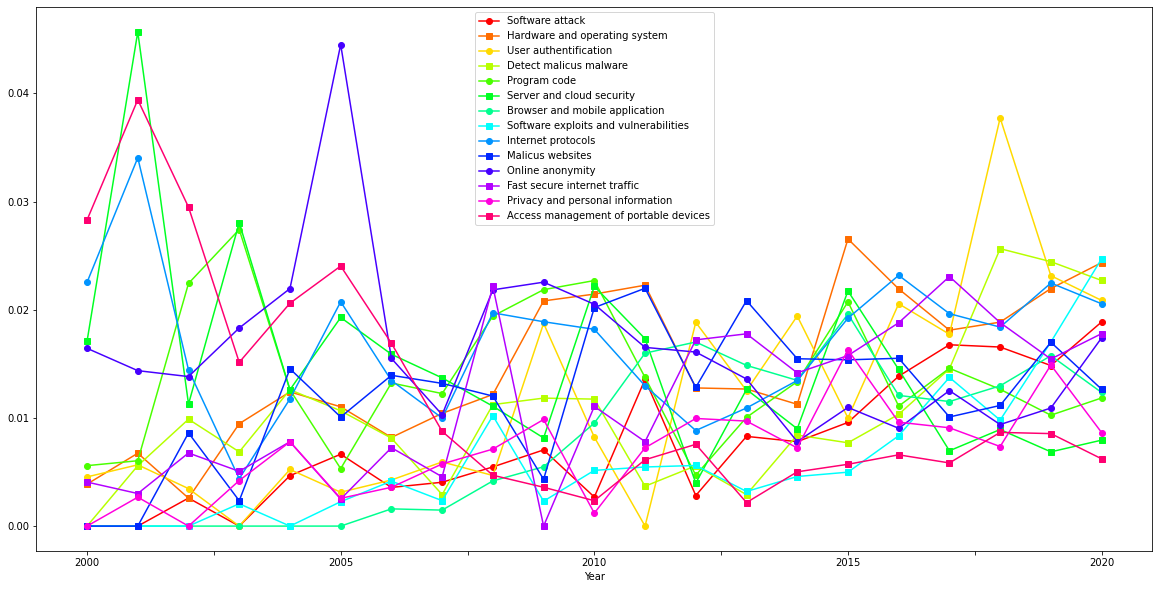

In [243]:
df_tec_perc_topic = df.copy()

perc = 0.2
a = 0
b = 0

for i in range(0,len(df_tec_perc_topic.index)):
    a = 0
    for j in range(0,14):
        if(j < 10):
            if (df_tec_perc_topic.at[i, 'Topic_0' + str(j)] >= perc ):
                a = 1
                continue
            else:
                df_tec_perc_topic.at[i, 'Topic_0' + str(j)] = 0
        else:
            if (df_tec_perc_topic.at[i, 'Topic_' + str(j)] >= perc ):
                a = 1
                continue
            else:
                df_tec_perc_topic.at[i, 'Topic_' + str(j)] = 0
    b += a
print(b, 'of', len(df_tec_perc_topic.index),'documents has a dominant topic over', perc)
            
df_tec_perc_topic = df_tec_perc_topic.groupby(['Year']).mean()

df_tec_perc_topic.columns = topicNames
plotGraph(df_tec_perc_topic)
df_tec_perc_topic
#plt.savefig('AllConfsAllTopics10%Significance.pdf')

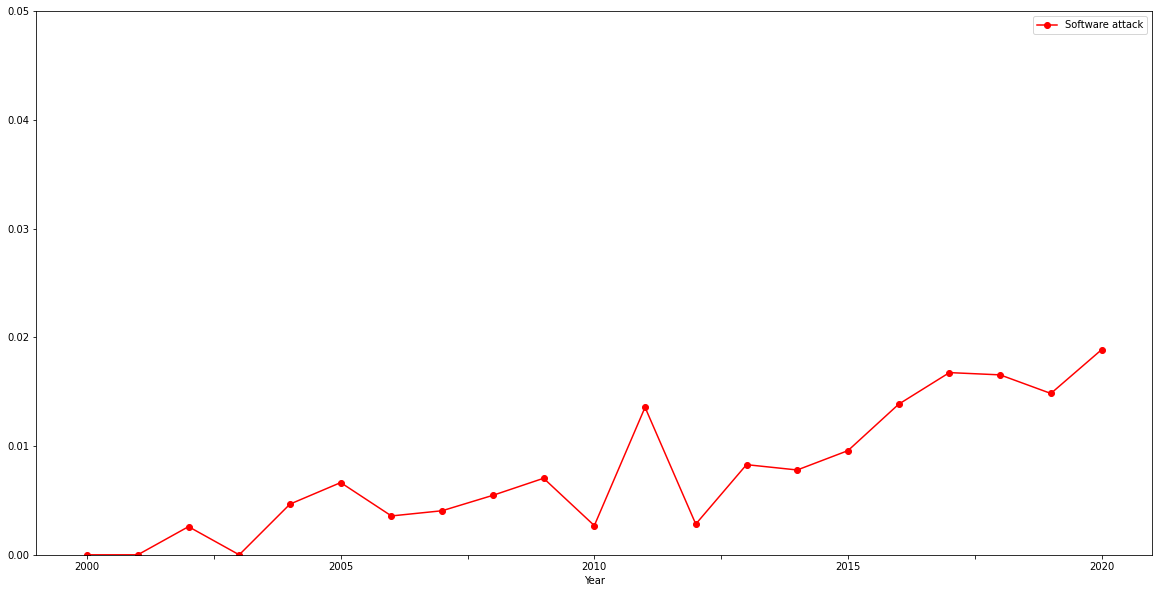

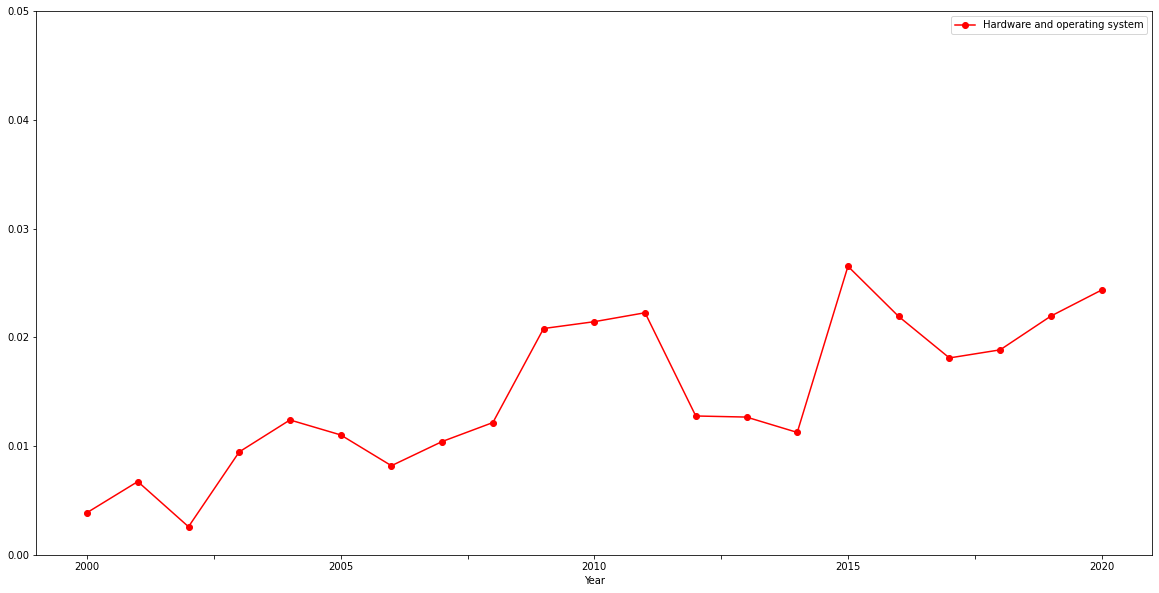

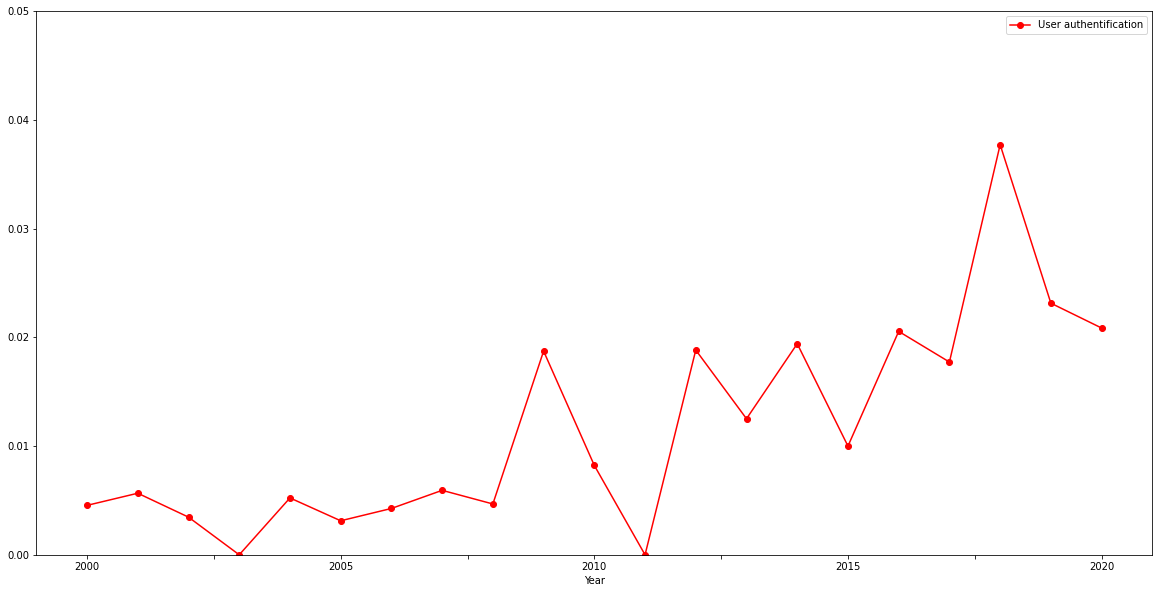

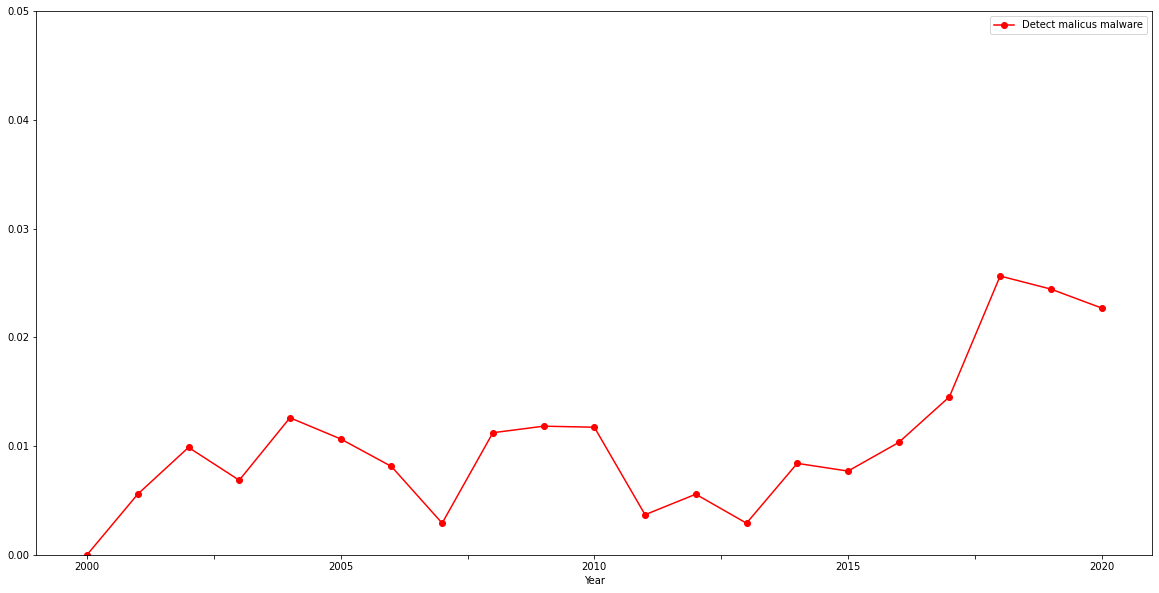

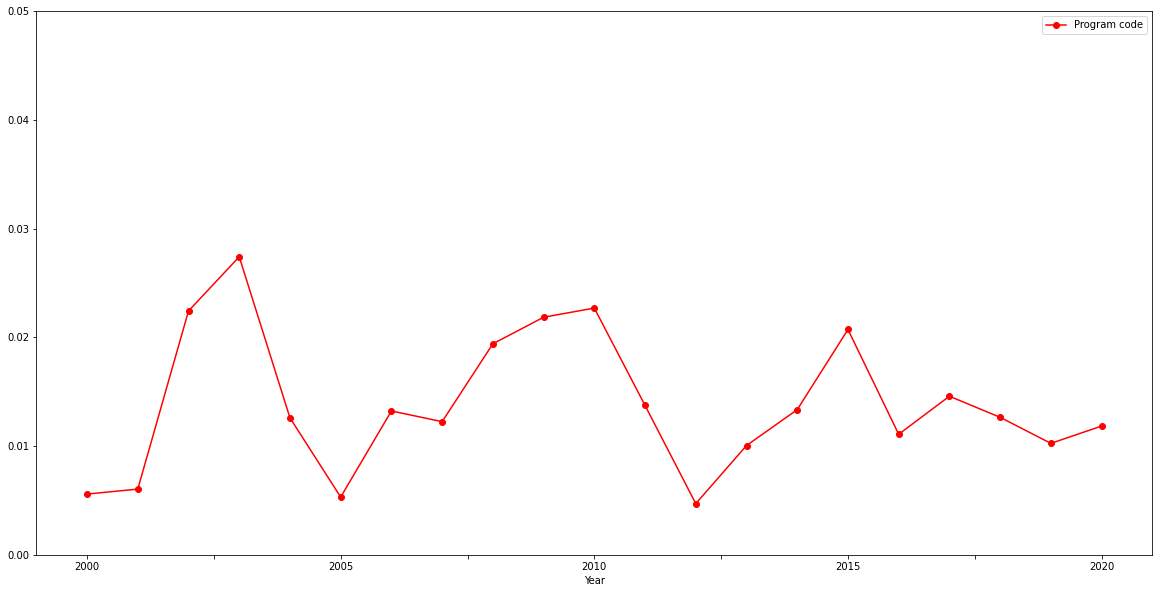

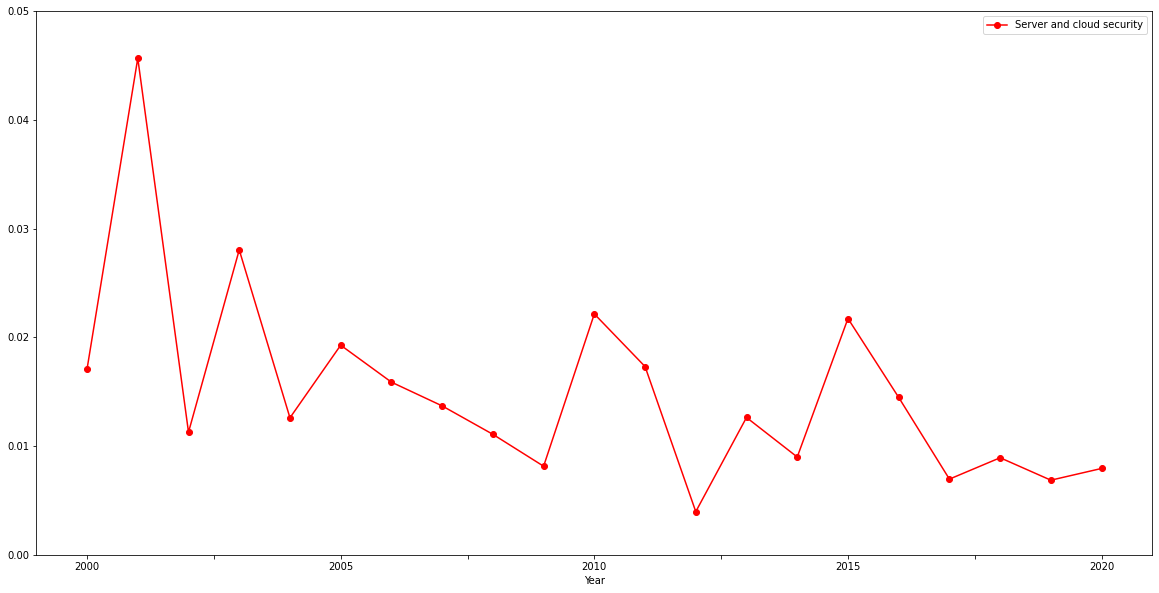

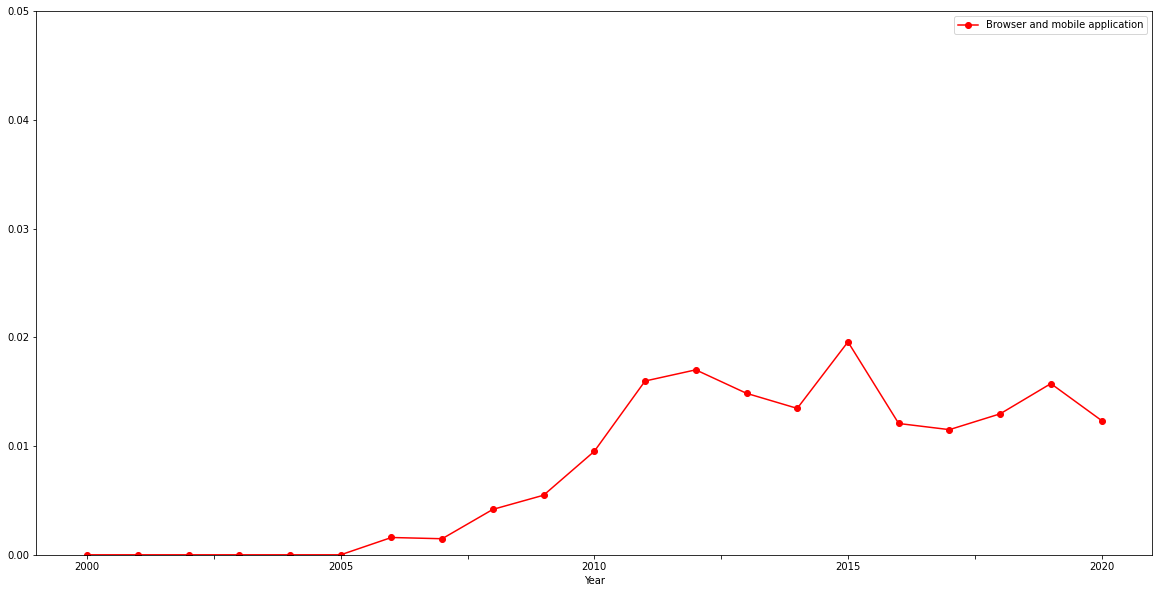

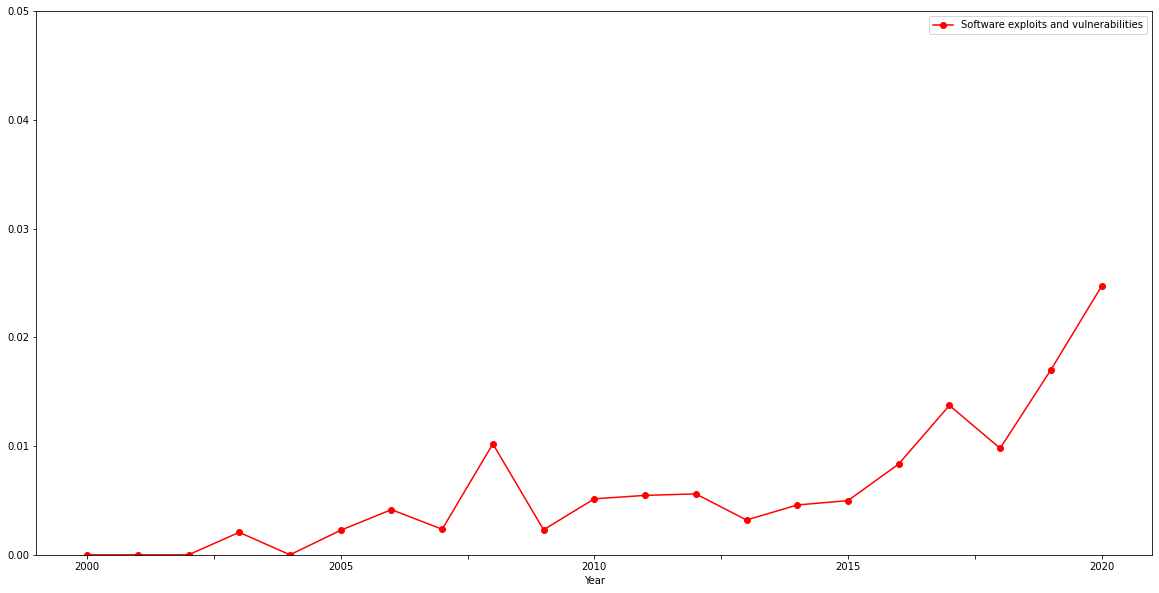

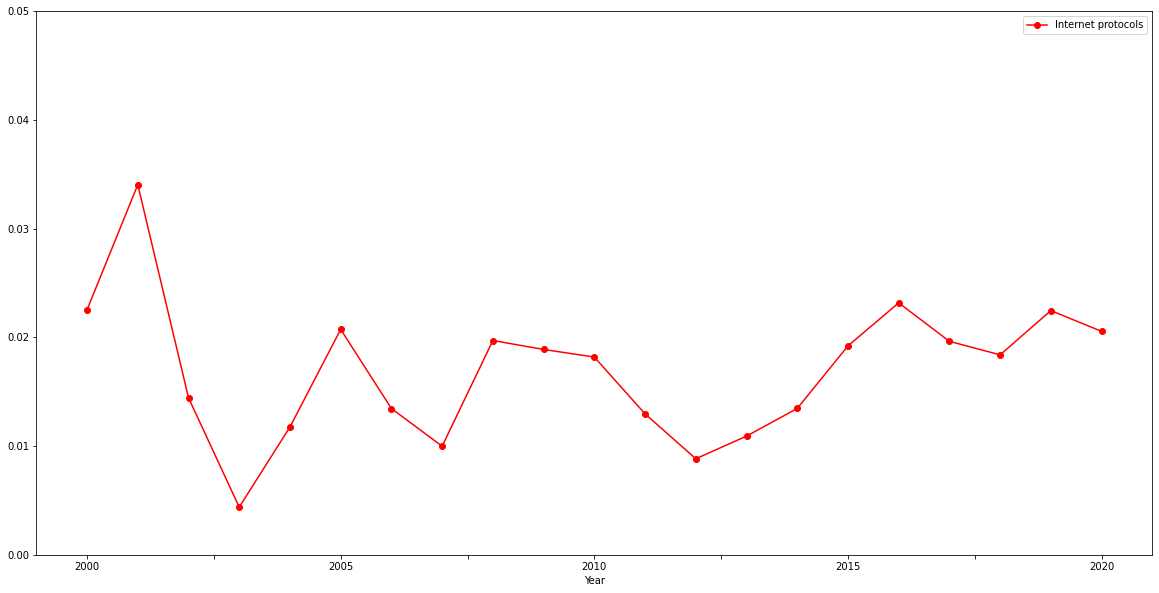

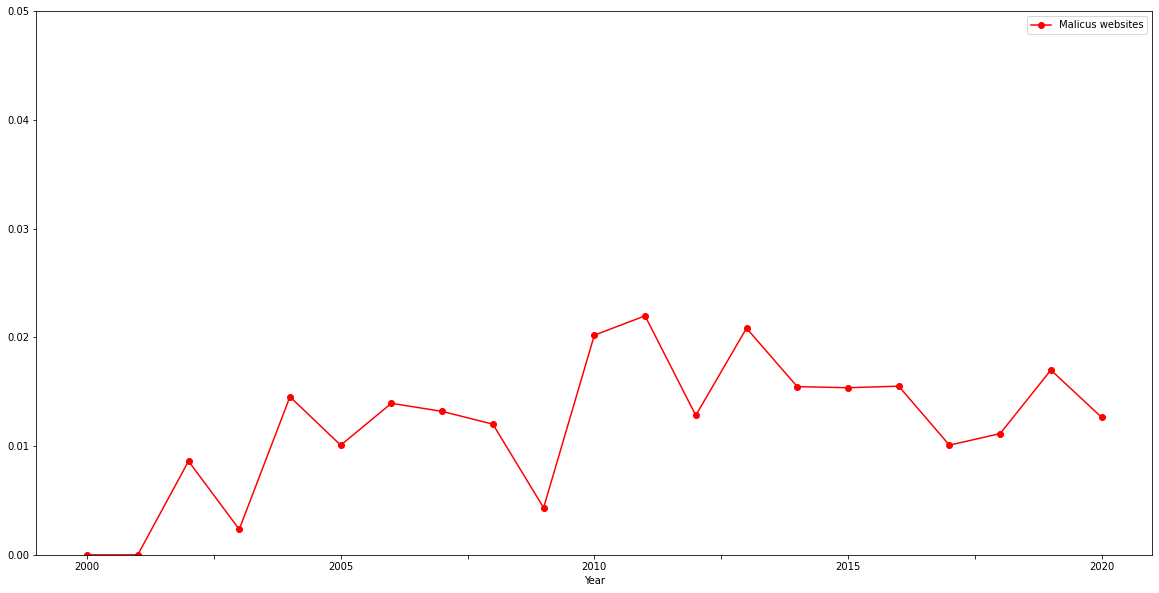

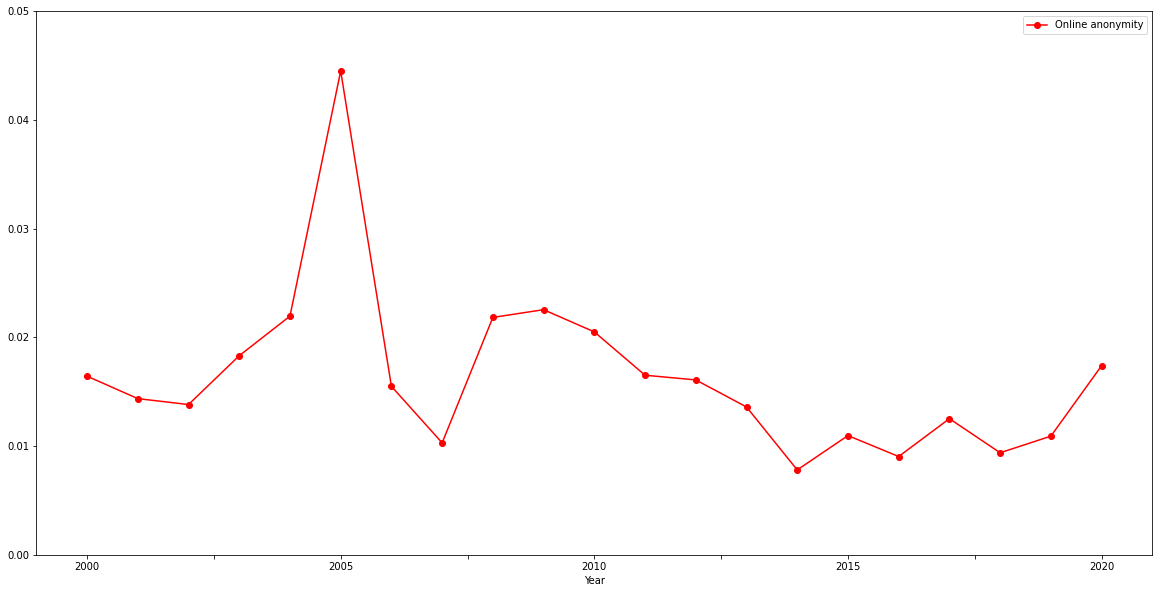

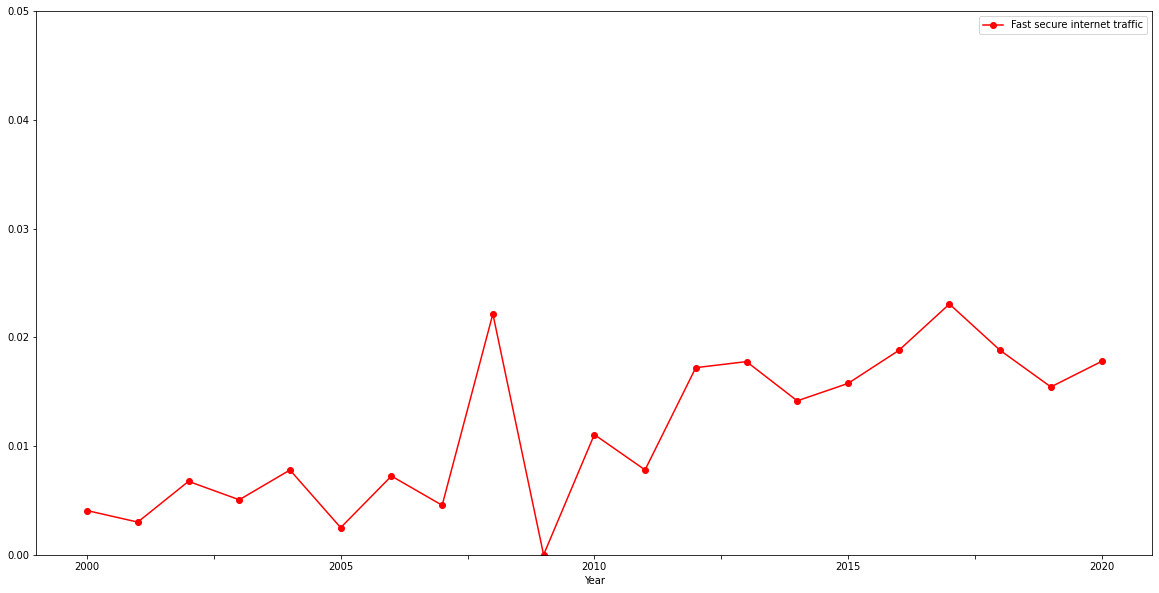

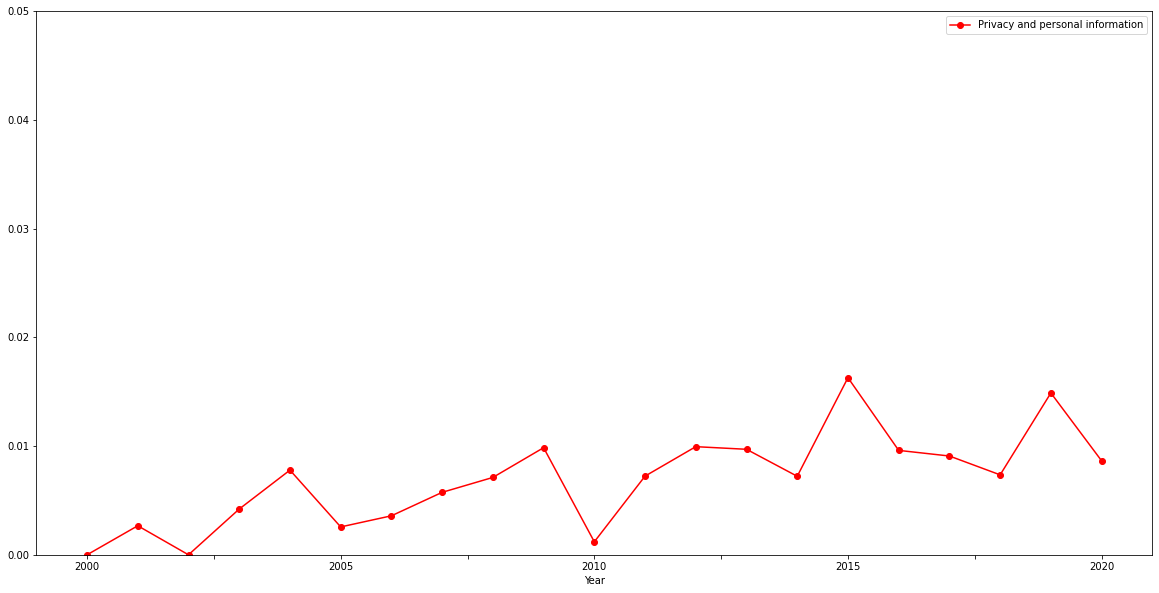

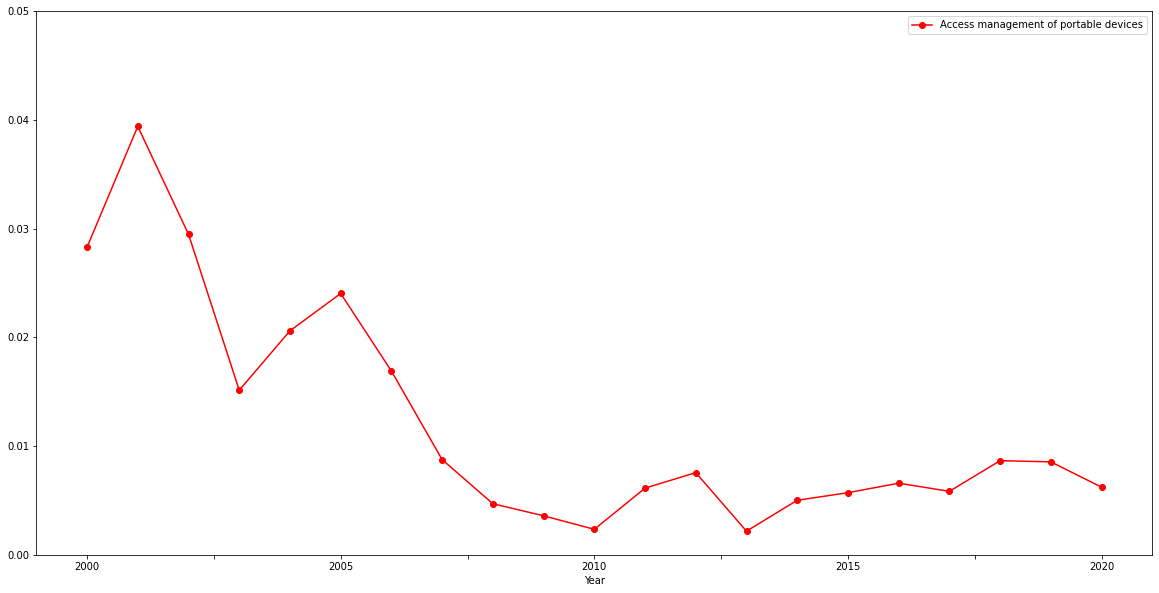

In [178]:
for i, topic in enumerate(topicNames):
    selectTopic = df_tec_perc_topic[[topicNames[i]]]
    dfTopic = selectTopic.copy()
    plotGraph(dfTopic)

## Plotting dominant topic distribution over years
Counts dominant topics for every year and plots it over all years

,Software attack,Hardware and operating system,User authentification,Detect malicus malware,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,
2000,0.001812,0.014085,0.009913,0.007032,0.011638,0.032213,0.002185,0.004669,0.032199,0.004146,0.024215,0.010202,0.002277,0.048616
2001,0.001446,0.009929,0.011083,0.010037,0.009965,0.054728,0.000000,0.005336,0.037564,0.002363,0.019463,0.004380,0.010382,0.042803
2002,0.011051,0.002020,0.007227,0.015346,0.029710,0.021316,0.000000,0.001242,0.020603,0.014323,0.025468,0.006756,0.003729,0.046097
2003,0.011723,0.016895,0.005066,0.006082,0.028726,0.044364,0.000000,0.007612,0.011201,0.007139,0.033010,0.008662,0.005930,0.019308
2004,0.007569,0.019460,0.005231,0.014190,0.018785,0.017248,0.000000,0.004214,0.018328,0.023461,0.040058,0.009051,0.007790,0.027815
2005,0.007645,0.016270,0.004718,0.016661,0.017043,0.030329,0.000000,0.007156,0.021789,0.011580,0.052718,0.004508,0.003984,0.027306
2006,0.009450,0.011936,0.011897,0.013988,0.017778,0.021121,0.003794,0.004943,0.019839,0.027762,0.027903,0.008925,0.005338,0.024926
2007,0.008758,0.015293,0.007788,0.006256,0.037519,0.017024,0.004210,0.005505,0.013679,0.016441,0.016361,0.008466,0.013136,0.012456
2008,0.008472,0.019807,0.004676,0.014286,0.019774,0.017069,0.005953,0.010201,0.025107,0.016656,0.032072,0.028787,0.013559,0.008909


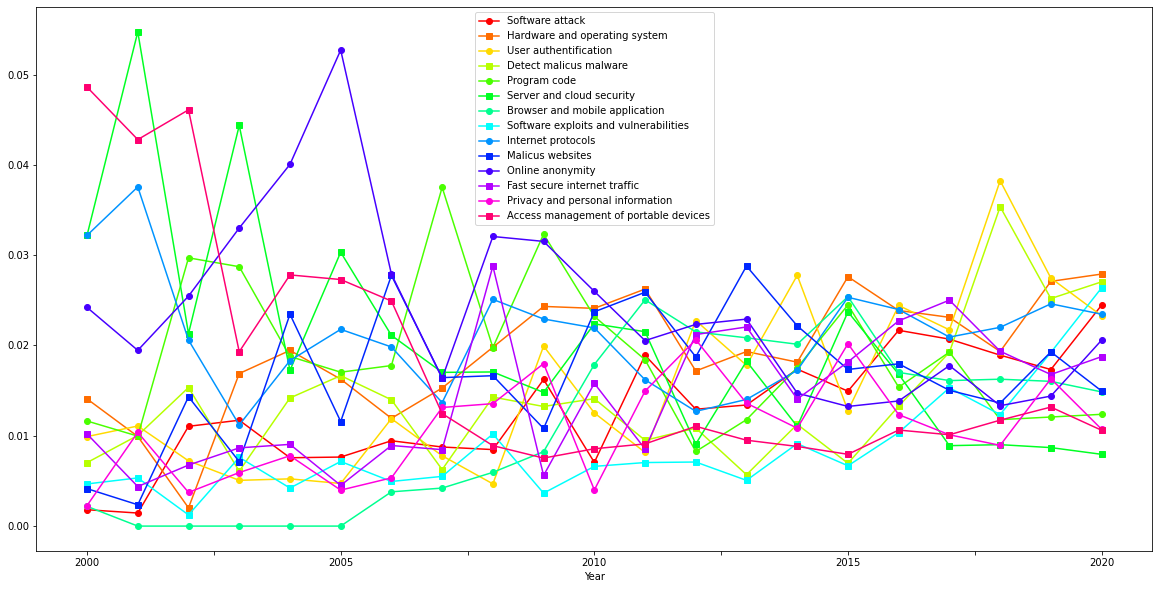

In [244]:
df_weight_dom_topics = df.copy()

for i in range(0,len(df_weight_dom_topics.index)):
    for j in range(0,10):
        if (df_weight_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_0' + str(j)):
            a = 0
            #df_weight_dom_topics.at[i, 'Topic_0' + str(j)] = 1
        else:
            df_weight_dom_topics.at[i, 'Topic_0' + str(j)] = 0
    for j in range(10,14):
        if (df_weight_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_' + str(j)):
            a = 0
            #df_weight_dom_topics.at[i, 'Topic_' + str(j)] = 1
        else:
            df_weight_dom_topics.at[i, 'Topic_' + str(j)] = 0


#df_weight_dom_topics = df_weight_dom_topics.groupby(['Year', 'Conf']).mean()
df_weight_dom_topics = df_weight_dom_topics.groupby(['Year']).mean()
df_weight_dom_topics.columns = topicNames
plotGraph(df_weight_dom_topics)
df_weight_dom_topics

,Software attack,Hardware and operating system,User authentification,Detect malicus malware,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,
2000,0.012500,0.075000,0.050000,0.050000,0.062500,0.137500,0.012500,0.037500,0.137500,0.025000,0.112500,0.050000,0.012500,0.225000
2001,0.012195,0.048780,0.060976,0.048780,0.048780,0.231707,0.000000,0.036585,0.158537,0.012195,0.097561,0.024390,0.060976,0.158537
2002,0.060976,0.012195,0.036585,0.073171,0.134146,0.109756,0.000000,0.012195,0.109756,0.073171,0.121951,0.024390,0.024390,0.207317
2003,0.077670,0.087379,0.029126,0.029126,0.116505,0.203883,0.000000,0.048544,0.067961,0.038835,0.155340,0.038835,0.029126,0.077670
2004,0.037736,0.094340,0.018868,0.056604,0.084906,0.084906,0.000000,0.028302,0.084906,0.113208,0.207547,0.037736,0.028302,0.122642
2005,0.042553,0.074468,0.021277,0.074468,0.095745,0.138298,0.000000,0.042553,0.085106,0.042553,0.223404,0.021277,0.021277,0.117021
2006,0.051471,0.051471,0.066176,0.073529,0.080882,0.088235,0.022059,0.022059,0.080882,0.139706,0.132353,0.044118,0.029412,0.117647
2007,0.047619,0.065476,0.029762,0.029762,0.339286,0.077381,0.023810,0.023810,0.059524,0.059524,0.071429,0.041667,0.071429,0.059524
2008,0.035714,0.095238,0.017857,0.059524,0.083333,0.077381,0.029762,0.041667,0.107143,0.077381,0.136905,0.119048,0.071429,0.047619


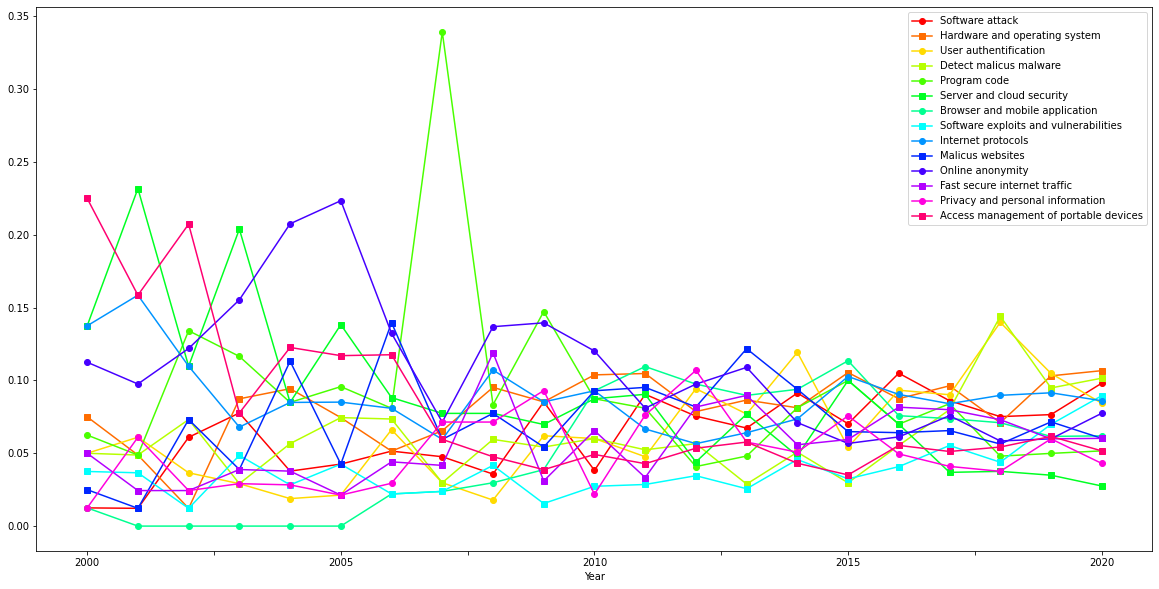

In [250]:
df_count_dom_topics = df.copy()

for i in range(0,len(df_count_dom_topics.index)):
    for j in range(0,10):
        if (df_count_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_0' + str(j)):
            df_count_dom_topics.at[i, 'Topic_0' + str(j)] = 1
        else:
            df_count_dom_topics.at[i, 'Topic_0' + str(j)] = 0

    for j in range(10,14):
        if (df_count_dom_topics.at[i, 'Dominant_Topic'] == 'Topic_' + str(j)):
            df_count_dom_topics.at[i, 'Topic_' + str(j)] = 1
        else:
            df_count_dom_topics.at[i, 'Topic_' + str(j)] = 0            

#df_count_dom_topics = df_count_dom_topics.groupby(['Year', 'Conf']).sum()
df_count_dom_topics = df_count_dom_topics.groupby(['Year']).mean()
df_count_dom_topics.columns = topicNames
plotGraph(df_count_dom_topics)
df_count_dom_topics

Number_of_Abstracts
Year Dominant_Topic                     
2000 Topic_00                          1
     Topic_01                          6
     Topic_02                          4
     Topic_03                          4
     Topic_04                          5
...                                  ...
2020 Topic_09                         35
     Topic_10                         45
     Topic_11                         35
     Topic_12                         25
     Topic_13                         30

[289 rows x 1 columns]

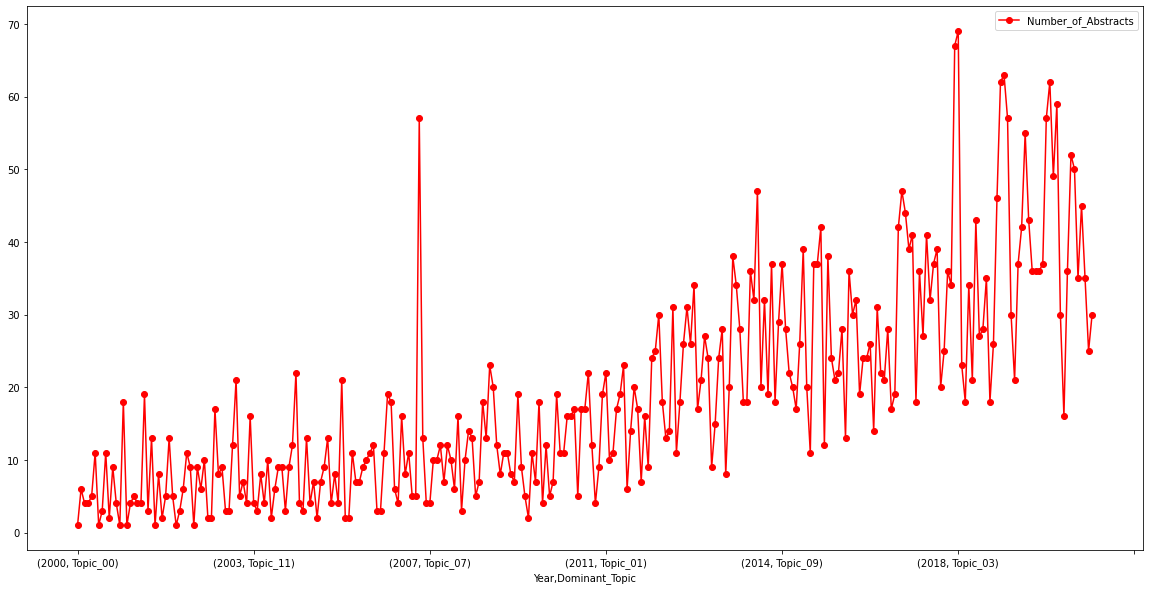

In [261]:
df_dominant_topic_ = df.groupby(['Year','Dominant_Topic']).count()
df_dom_top = df_dominant_topic_[['Authors']]
df_dom_top.columns = ['Number_of_Abstracts']
df.to_csv('DF.csv')
plotGraph(df_dom_top)
df_dom_top

## Plotting topic distribution over years

,Software attack,Hardware and operating system,User authentification,Detect malicus malware,Program code,Server and cloud security,Browser and mobile application,Software exploits and vulnerabilities,Internet protocols,Malicus websites,Online anonymity,Fast secure internet traffic,Privacy and personal information,Access management of portable devices
Year,,,,,,,,,,,,,,
2000,0.053168,0.071660,0.065418,0.059491,0.070031,0.094920,0.058115,0.057034,0.093303,0.057934,0.081792,0.069431,0.064685,0.103018
2001,0.053562,0.065575,0.067757,0.059402,0.070553,0.116909,0.051358,0.055252,0.099897,0.056076,0.071806,0.069897,0.063662,0.098294
2002,0.064052,0.067986,0.062915,0.071515,0.082056,0.082309,0.054574,0.059440,0.086935,0.064123,0.083240,0.067580,0.057007,0.096267
2003,0.071194,0.072862,0.058201,0.066123,0.086207,0.096315,0.053807,0.063224,0.073705,0.060193,0.088741,0.070747,0.061146,0.077534
2004,0.062626,0.073961,0.063369,0.073948,0.073083,0.080132,0.050774,0.057987,0.074273,0.079815,0.088274,0.068133,0.068488,0.085136
2005,0.073405,0.072911,0.054477,0.070112,0.076343,0.082720,0.048694,0.061799,0.083347,0.066876,0.103213,0.065681,0.062638,0.077782
2006,0.068679,0.063562,0.065032,0.072783,0.073427,0.077994,0.057106,0.064251,0.076461,0.080640,0.084984,0.067292,0.065088,0.082700
2007,0.068960,0.072417,0.064195,0.067560,0.076199,0.082035,0.061376,0.064670,0.074864,0.074124,0.075652,0.071063,0.072842,0.074043
2008,0.065736,0.071781,0.061147,0.071692,0.076654,0.074373,0.058086,0.069423,0.074536,0.069484,0.083086,0.083860,0.068072,0.072071


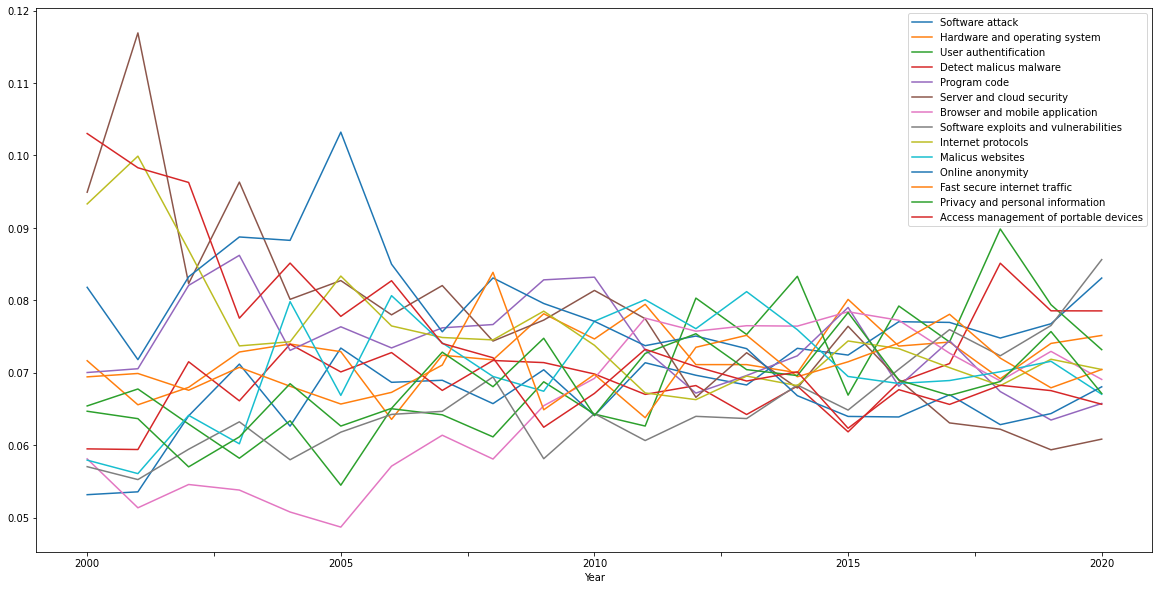

In [190]:
# Topic distribution over year graph
df_joined_year = df.copy()
df_joined_year = df_joined_year.groupby(['Year']).mean()
df_joined_year.columns = topicNames
#plotGraph(df_joined_year)
df_joined_year.plot(figsize=(20,10))
df_joined_year

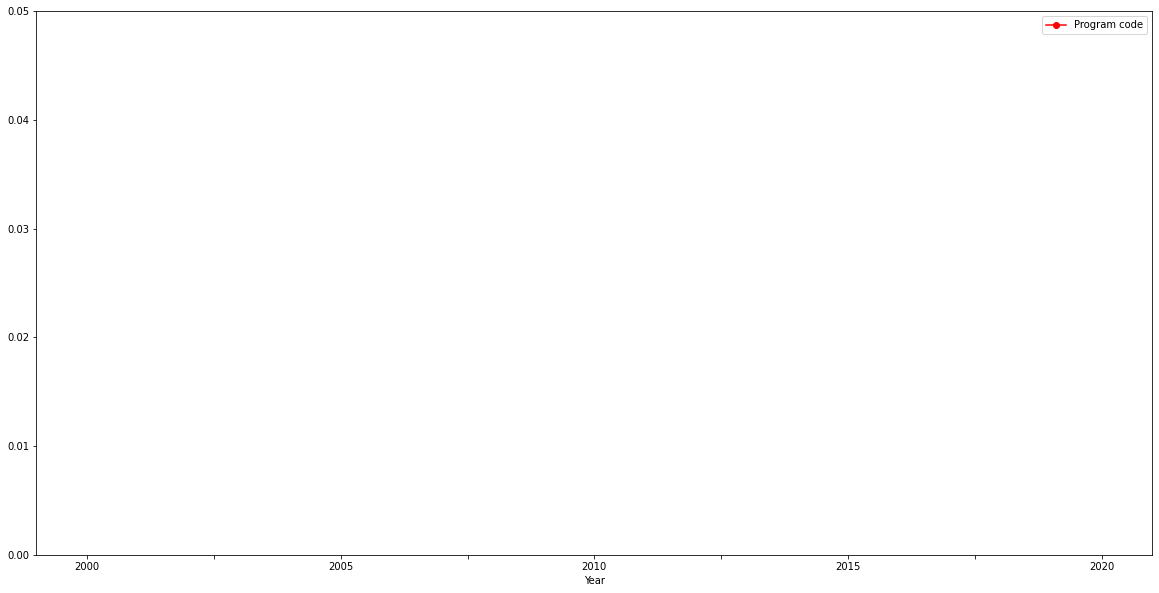

In [186]:
one_topic = df_joined_year[['Program code']]


df_joined_year_one_topic = one_topic.copy()
df_joined_year_one_topic

plotGraph(df_joined_year_one_topic)


### CCS graph

In [220]:
# Topic distribution over year graph for CSS
df_css = df[df['Conf'] == 'CSS'].groupby(['Year']).mean()
#df_css.columns = topicNames
#df_css.plot(figsize=(20,10))
#plotGraph(df_css)
df_css
#plotGraph(df[df['Conf'] == 'CSS'])
df_test = df[df['Conf'] == 'CSS']
df_test[df_test['Year'] == '2000']
#plotGraph(df_test[df_test['Year'] == '2000'])

,Year,Conf,Authors,Dominant_Topic,Topic_00,Topic_01,Topic_02,Topic_03,Topic_04,Topic_05,Topic_06,Topic_07,Topic_08,Topic_09,Topic_10,Topic_11,Topic_12,Topic_13
1662,2000,CSS,"John Iliadis, Diomidis Spinellis, Dimitris Gri...",Topic_01,0.055745,0.055745,0.087491,0.054422,0.062358,0.074263,0.053099,0.098073,0.075586,0.070295,0.066327,0.079554,0.094104,0.072940
1663,2000,CSS,"Ahto Buldas, Peeter Laud, Helger Lipmaa',",Topic_01,0.031746,0.035359,0.059750,0.037166,0.041683,0.061556,0.054330,0.048910,0.322622,0.033553,0.039876,0.057943,0.078720,0.096787
1664,2000,CSS,"Rebecca N. Wright, Patrick Lincoln, Jonathan K...",Topic_01,0.035072,0.036130,0.103855,0.043537,0.041421,0.163114,0.036130,0.041421,0.111262,0.119728,0.139834,0.043537,0.049887,0.035072
1665,2000,CSS,"Edward W. Felten, Michael A. Schneider',",Topic_01,0.144983,0.065618,0.050737,0.050737,0.042800,0.057681,0.142007,0.042800,0.044785,0.105300,0.064626,0.037840,0.108277,0.041808
1666,2000,CSS,"Clay Shields, Brian Neil Levine',",Topic_01,0.044380,0.043246,0.063654,0.057985,0.036443,0.082928,0.037577,0.048915,0.087464,0.044380,0.230321,0.109006,0.077259,0.036443
1667,2000,CSS,"Manfred Hauswirth, Clemens Kerer, Roman Kurman...",Topic_01,0.034290,0.070615,0.029304,0.044261,0.108364,0.066341,0.105515,0.032865,0.050672,0.027167,0.070615,0.033578,0.045686,0.280729
1668,2000,CSS,"Pino Persiano, Ivan Visconti',",Topic_01,0.048987,0.059524,0.050903,0.034620,0.054735,0.116995,0.057608,0.055692,0.132321,0.036535,0.065271,0.062397,0.182129,0.042282
1669,2000,CSS,"Glenn Durfee, Matthew K. Franklin',",Topic_01,0.068161,0.057703,0.059010,0.070775,0.076004,0.073389,0.048553,0.042017,0.176657,0.060317,0.051167,0.061625,0.066853,0.087768
1670,2000,CSS,"Joachim Biskup, Ulrich Flegel',",Topic_01,0.047619,0.036832,0.087533,0.065958,0.054092,0.057328,0.057328,0.055170,0.144706,0.070273,0.045462,0.108029,0.078903,0.090769
1671,2000,CSS,"Yuji Watanabe, Hideki Imai',",Topic_01,0.049192,0.046189,0.032175,0.055198,0.035178,0.109252,0.038181,0.047190,0.057200,0.048191,0.048191,0.325468,0.065208,0.043186


### IEEE graph

2000


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2000,0.058362,0.058738,0.058858,0.059212,0.058439,0.059044,0.059469,0.059181,0.058515,0.058242,0.058098,0.057946,0.058124,0.060268,0.059000,0.059313,0.059191
2001,0.059277,0.058894,0.058498,0.059446,0.059081,0.059146,0.059711,0.058479,0.059938,0.057263,0.057938,0.057712,0.058930,0.059264,0.058730,0.057540,0.060153
2002,0.058965,0.058001,0.058531,0.059628,0.059085,0.059365,0.058891,0.058575,0.058322,0.057635,0.058667,0.058310,0.059497,0.059392,0.059549,0.058445,0.059142
2003,0.059472,0.059217,0.058026,0.058825,0.058802,0.059408,0.060282,0.058152,0.058093,0.057877,0.058505,0.057106,0.058755,0.059831,0.059736,0.058492,0.059422
2004,0.059378,0.058014,0.058715,0.059671,0.058371,0.060422,0.059217,0.058205,0.058896,0.057582,0.057868,0.057419,0.059561,0.059795,0.059429,0.057878,0.059581
2005,0.058178,0.060668,0.059912,0.058707,0.058125,0.058666,0.059187,0.057160,0.059889,0.056993,0.058998,0.057639,0.060396,0.059702,0.059258,0.057593,0.058930
2006,0.058431,0.059142,0.058855,0.059134,0.058847,0.059153,0.058885,0.059562,0.058421,0.057238,0.058813,0.058381,0.059084,0.058837,0.059139,0.058323,0.059754
2007,0.058068,0.059244,0.058154,0.059259,0.058576,0.059237,0.059553,0.057944,0.059117,0.058252,0.058381,0.058779,0.058914,0.059169,0.059172,0.058297,0.059885
2008,0.059042,0.059204,0.059299,0.058886,0.058759,0.058466,0.059140,0.058301,0.058851,0.057287,0.059232,0.057531,0.058928,0.060559,0.059372,0.057933,0.059208


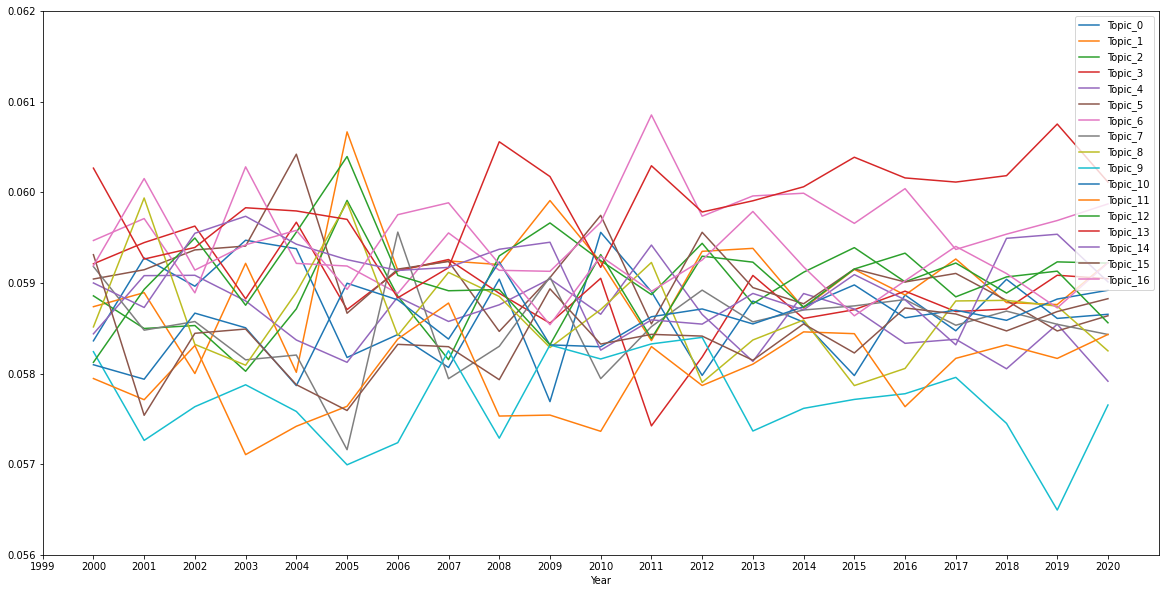

In [45]:
# Topic distribution over year graph for IEEE
df_ieee = df[df['Conf'] == 'IEEE'].groupby(['Year']).mean()
plotGraph(df_ieee)
df_ieee

### USENIX graph

2012


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2012,0.059461,0.059086,0.058865,0.059161,0.058338,0.058893,0.059086,0.058771,0.058752,0.058247,0.058652,0.057783,0.059261,0.059915,0.058529,0.058525,0.058674
2013,0.059070,0.058815,0.058352,0.059276,0.058412,0.058551,0.059210,0.058697,0.059049,0.057945,0.058724,0.058098,0.059789,0.059750,0.058870,0.058435,0.058957
2014,0.059571,0.058955,0.058275,0.059253,0.058798,0.058777,0.059436,0.058436,0.058927,0.058306,0.058417,0.058266,0.059049,0.059652,0.058751,0.058663,0.058468
2015,0.059445,0.059162,0.057827,0.059112,0.058376,0.058389,0.059416,0.058650,0.060089,0.057861,0.058741,0.057717,0.059497,0.059201,0.058701,0.058768,0.059050
2016,0.059455,0.059643,0.057832,0.059124,0.058645,0.058387,0.059508,0.058367,0.059486,0.057844,0.058048,0.058040,0.059408,0.059494,0.058931,0.059200,0.058587
2017,0.059423,0.059122,0.058518,0.059375,0.058454,0.058800,0.059209,0.058833,0.059400,0.057515,0.057949,0.057860,0.059841,0.059889,0.058612,0.058769,0.058432
2018,0.059115,0.059305,0.058664,0.059212,0.058664,0.058966,0.059102,0.058332,0.059001,0.057857,0.058299,0.057961,0.059277,0.059719,0.058769,0.058967,0.058792
2019,0.059587,0.059250,0.058662,0.058977,0.058812,0.058181,0.059408,0.058336,0.059284,0.057348,0.058022,0.058100,0.059316,0.060276,0.058808,0.058894,0.058739
2020,0.059192,0.059016,0.058626,0.059192,0.058743,0.058782,0.058694,0.058433,0.059829,0.057700,0.058003,0.057661,0.059477,0.059806,0.058833,0.058991,0.059020


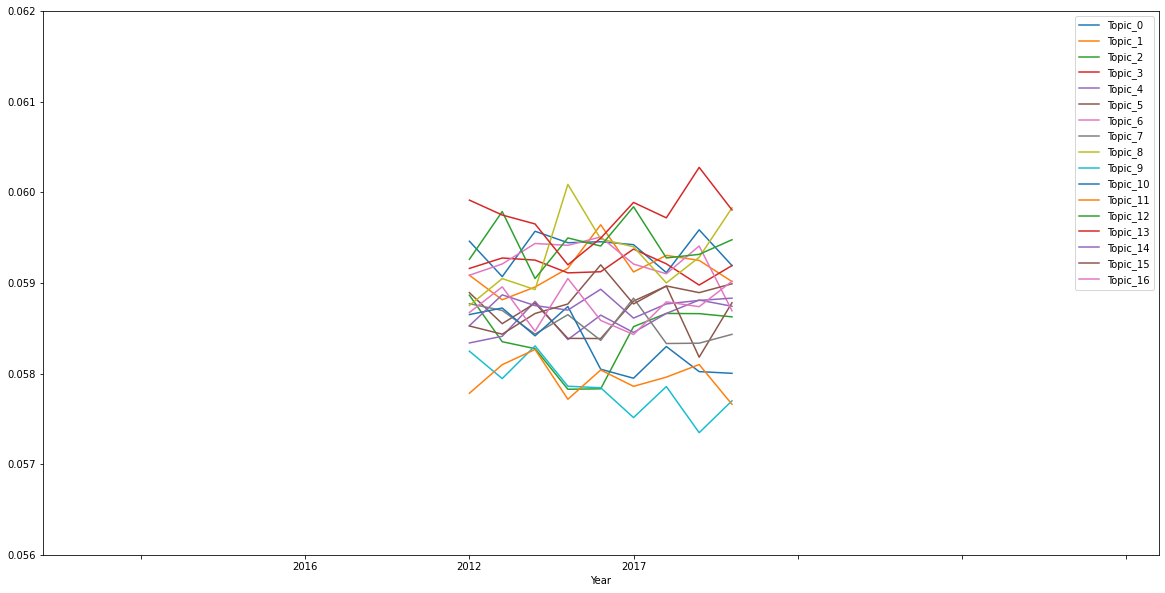

In [118]:
# Topic distribution over year graph for USENIX
df_usenix = df[df['Conf'] == 'Usenix'].groupby(['Year']).mean()
plotGraph(df_usenix)
df_usenix

### NDSS graph

2012


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2012,0.058988,0.058910,0.058703,0.059077,0.058616,0.058735,0.058996,0.058560,0.059044,0.058400,0.058797,0.058717,0.058941,0.059141,0.058973,0.058610,0.058792
2013,0.059125,0.059286,0.058651,0.059037,0.058674,0.058587,0.058669,0.058519,0.058797,0.058495,0.058770,0.058474,0.059018,0.059362,0.058709,0.058704,0.059121
2014,0.059001,0.058933,0.058761,0.058881,0.058827,0.058807,0.058972,0.058705,0.059137,0.058459,0.058710,0.058830,0.058778,0.059171,0.058544,0.058860,0.058624
2015,0.059146,0.058496,0.058269,0.059005,0.059192,0.058357,0.060224,0.058636,0.059404,0.057253,0.058088,0.057858,0.059949,0.060107,0.059261,0.058873,0.057882
2016,0.058663,0.058802,0.058680,0.059426,0.060262,0.059426,0.058831,0.059405,0.058837,0.057823,0.057569,0.058538,0.061196,0.057370,0.058212,0.057710,0.059250
2017,0.059570,0.059078,0.058535,0.059355,0.058654,0.058251,0.059475,0.058544,0.059430,0.057681,0.057933,0.057668,0.059769,0.059253,0.058772,0.058699,0.059333
2019,0.058829,0.060031,0.058539,0.059414,0.059542,0.059440,0.058573,0.058298,0.059822,0.056580,0.057619,0.057363,0.060841,0.060945,0.058368,0.058101,0.057693
2020,0.058873,0.060305,0.059427,0.060627,0.057744,0.058666,0.058687,0.058738,0.060107,0.056177,0.056344,0.057300,0.060659,0.060764,0.058024,0.059177,0.058380


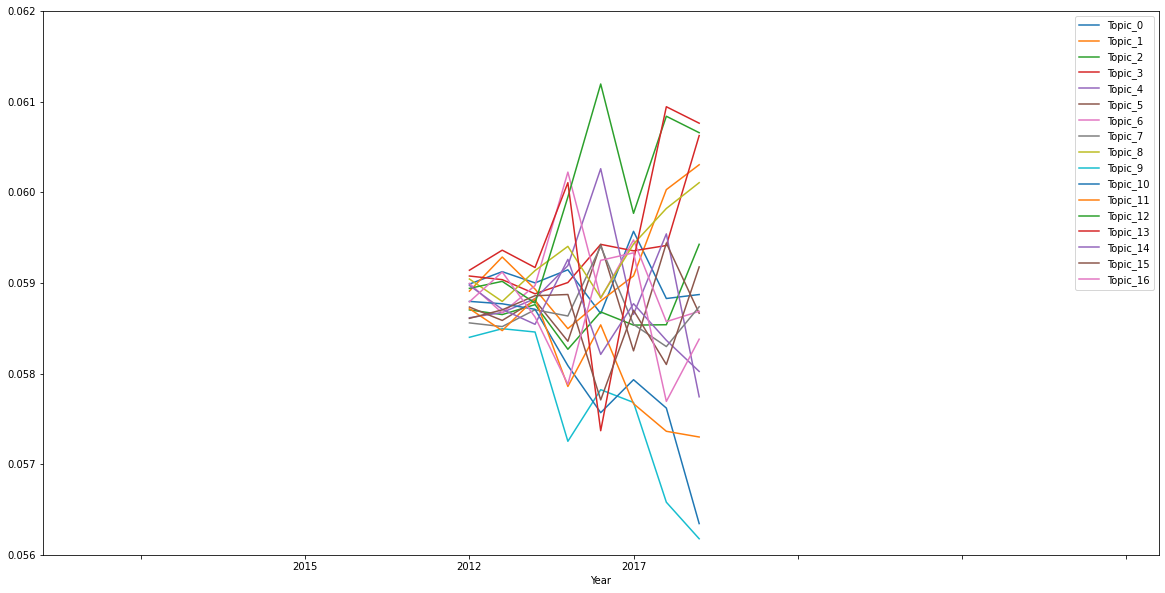

In [119]:
# Topic distribution over year graph for NDSS
df_ndss = df[df['Conf'] == 'NDSS'].groupby(['Year']).mean()
plotGraph(df_ndss)
df_ndss